<a href="https://colab.research.google.com/github/JoaoBarroso4/rede_neural_do_zero/blob/main/Rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
transform = transforms.ToTensor() # convertendo a imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega o dataset de treino
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carrega o dataset de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes

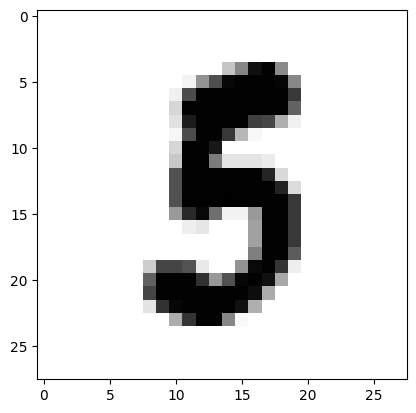

In [24]:
dataiter = iter(trainloader)

imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap="gray_r")

In [25]:
print(imagens[0].shape) # verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [26]:
# valores padrões para a rede inception v3
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
    # não é necessário definir nada para a camada de saída, pois só precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída. nesse caso, f(x) = x
    return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [27]:
def treino(modelo, trainLoader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e bias
  inicio = time() # timer para sabermos quanto tempo durou o treino

  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 10 # número de epochs que o algoritmo rodará (ideal ~ 100)
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atualizando os pesos e bias

      perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ", (time() - inicio)/60)

In [28]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  y_true = []
  y_pred = []

  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o autograd para acelerar a validação. grafos computacionais dinâmicos têm um custo de alto processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logarítmica


      ps = torch.exp(logps) # converte o output para escala normal (lembrete: é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu
      etiqueta_certa = etiquetas.numpy()[i]

      y_true.append(etiqueta_certa)
      y_pred.append(etiqueta_pred)

      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [29]:
modelo = Modelo() # incializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [30]:
# Treinar o modelo
treino(modelo, trainloader, device)

Epoch 1 - Perda resultante: 1.202269459361715
Epoch 2 - Perda resultante: 0.3847801157279309
Epoch 3 - Perda resultante: 0.3124027294613151
Epoch 4 - Perda resultante: 0.27320297537391375
Epoch 5 - Perda resultante: 0.2432949247279528
Epoch 6 - Perda resultante: 0.218081542944063
Epoch 7 - Perda resultante: 0.19658330883949932
Epoch 8 - Perda resultante: 0.17858632115412876
Epoch 9 - Perda resultante: 0.16304299115801035
Epoch 10 - Perda resultante: 0.14910836852411788

Tempo de treino (em minutos) =  1.7080820480982462


In [31]:
# Validar o modelo
validacao(modelo, valloader, device)

Total de imagens testadas = 10000

Precisão do modelo = 95.62%


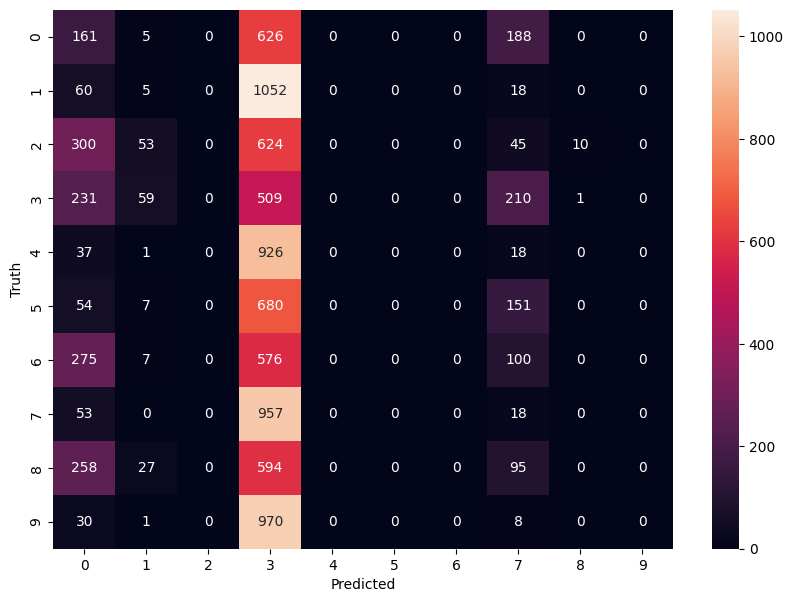

In [32]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [33]:
accuracy = np.trace(cm) / np.sum(cm).astype('float')
print(f'Acurácia: {accuracy}')
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
print(f'Precisão: {precision}')
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(f'Recall: {recall}')
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1-Score: {f1_score}')

Acurácia: 0.0693
Precisão: 0.5
Recall: 0.07692307692307693
F1-Score: 0.13333333333333336
